# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##  you can  download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [13]:
import os
import pandas as pd
import geopandas as gpd
import zipfile 

In [7]:
#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
for y in range(93,100):
    filename = 'zbp'+str(y)+'totals.zip'
    os.system('wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/'+filename)
    os.system('mv '+filename + ' ' + os.getenv("PUIDATA") + '/ecoCensus/')
    

In [8]:
#!for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
#!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

#IMPORTANTE
#The instructions look in the directories econ2000 and econ2001 which do not exist. Both data files are in Econ2001_And_Earlier like the data files from the 90s.


for y in range(2000,2016):
    
    if y <= 2010:
        filename = 'zbp'+str(y)[1:]+'totals.zip'
        #ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip
        
    else:
        filename = 'zbp'+str(y)+'totals.zip'
        #ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip
        
    print filename 
    #os.system('wget ftp://ftp.census.gov/econ'+ str(y) + '/CBP_CSV/' = filename)
    #os.system('mv '+filename + ' ' + os.getenv("PUIDATA"))
    


zbp000totals.zip
zbp001totals.zip
zbp002totals.zip
zbp003totals.zip
zbp004totals.zip
zbp005totals.zip
zbp006totals.zip
zbp007totals.zip
zbp008totals.zip
zbp009totals.zip
zbp010totals.zip
zbp2011totals.zip
zbp2012totals.zip
zbp2013totals.zip
zbp2014totals.zip
zbp2015totals.zip


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [ ]:
#ZIPCODES

url = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/'
filename = 'nyc-zip-code-tabulation-areas-polygons.geojson'
os.system('wget '+ url + filename)

os.system('mv ' + filename + ' ' + os.getenv("PUIDATA"))

In [ ]:
zipcodes = gpd.read_file(os.getenv("PUIDATA") +'/' + filename)
zipcodes = zipcodes.loc[:,['OBJECTID','PO_NAME','borough','geometry','postalCode']]
zipcodes.postalCode = zipcodes.postalCode.astype(int)

In [17]:
zipcodes.head()

,OBJECTID,PO_NAME,borough,geometry,postalCode
0,1,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,2,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,3,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,4,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,5,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [89]:
zipcodes.isnull().sum()

OBJECTID      0
PO_NAME       0
borough       0
geometry      0
postalCode    0
dtype: int64

In [61]:
f = []
for (dirpath, dirnames, filenames) in os.walk(os.getenv("PUIDATA") +'/ecoCensus/'):
    f.extend(filenames)
    break
f

['zbp94totals.zip',
 'zbp98totals.zip',
 'zbp99totals.zip',
 'zbp97totals.zip',
 'zbp96totals.zip',
 'zbp95totals.zip']

In [83]:
#REMOVE THIS FILENAME AFTER
years = range(1994,2000)
mergeData = zipcodes.copy()
for i in range(len(f)):
    filename = f[i]
    zf = zipfile.ZipFile(os.getenv("PUIDATA") +'/ecoCensus/' + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
    #change this to upper case later
    df = df.iloc[:,[0,6]]
    df.columns = ['postalCode',str(years[i])]
    mergeData = pd.merge(left=mergeData,right=df,on = 'postalCode',how='left')


In [84]:
mergeData.head()

,OBJECTID,PO_NAME,borough,geometry,postalCode,1994,1995,1996,1997,1998,1999
0,1,Jackson Heights,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1229.0,1351.0,1376.0,1309.0,1292.0,1236.0
1,2,Glen Oaks,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,194.0,194.0,186.0,192.0,176.0,188.0
2,3,New Hyde Park,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1422.0,1344.0,1350.0,1344.0,1335.0,1414.0
3,4,Bellerose,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,326.0,203.0,217.0,198.0,209.0,219.0
4,5,Fresh Meadows,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,492.0,509.0,519.0,522.0,483.0,476.0


In [92]:
#normalizing variables
def normalizeCol(column):
    return (column - column.mean())/column.std()

In [108]:
column = mergeData['1994']
(column - column.mean())/column.std()
for col in mergeData.columns[4:]:
    mergeData[col] = (mergeData[col] - mergeData[col].mean())/mergeData[col].std()
    print col
    print mergeData[col].mean(), mergeData[col].std()
    #print mergeData[col].isnull().sum


postalCode
1.48312236114e-18 1.0
1994
-2.65582762753e-17 1.0
1995
-1.67414583078e-17 1.0
1996
2.80899801411e-17 1.0
1997
9.69242323085e-18 1.0
1998
-1.05735526155e-17 1.0
1999
2.12313566462e-17 1.0


In [127]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
X = np.matrix(mergeData.iloc[:,4:])
X = np.where(np.isnan(X),0,X)


In [129]:
maxK = 10

for n_clusters in range(2,maxK):
    #run the clustering
    km = KMeans(n_clusters=n_clusters, random_state=123)
    #assign labels of clusters
    cluster_labels = km.fit_predict(X)
    #calculate average for each cluster
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.819541546734
For n_clusters =3, the average silhouette_score is :0.553913775985
For n_clusters =4, the average silhouette_score is :0.546002286827
For n_clusters =5, the average silhouette_score is :0.474304125258
For n_clusters =6, the average silhouette_score is :0.489370638254
For n_clusters =7, the average silhouette_score is :0.507182115958
For n_clusters =8, the average silhouette_score is :0.510957246608
For n_clusters =9, the average silhouette_score is :0.51743209096


In [125]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

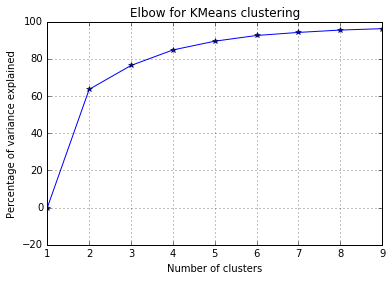

In [128]:
elbow(X, range(1,10))

In [132]:

#train the model.
km2=KMeans(random_state=324,n_clusters=2)
res2=km2.fit(X)
km4=KMeans(random_state=324,n_clusters=4)
res4=km4.fit(X)

mergeData['k2'] = res2.labels_ 
mergeData['k4'] = res4.labels_ 

In [155]:
print res2.cluster_centers_
res2.cluster_centers_[0,0]
res2.cluster_centers_[1,0]

[[ 0.03353085 -0.18624668 -0.18422339 -0.18259858 -0.18484715 -0.18491343
  -0.18509972]
 [-0.6985593   3.88013912  3.83798731  3.80413714  3.85098233  3.85236317
   3.85624408]]


-0.69855930375345898

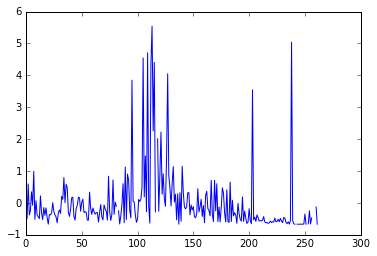

In [150]:
plt.plot(mergeData['1994'])
plt.plot(mergeData['1994'])

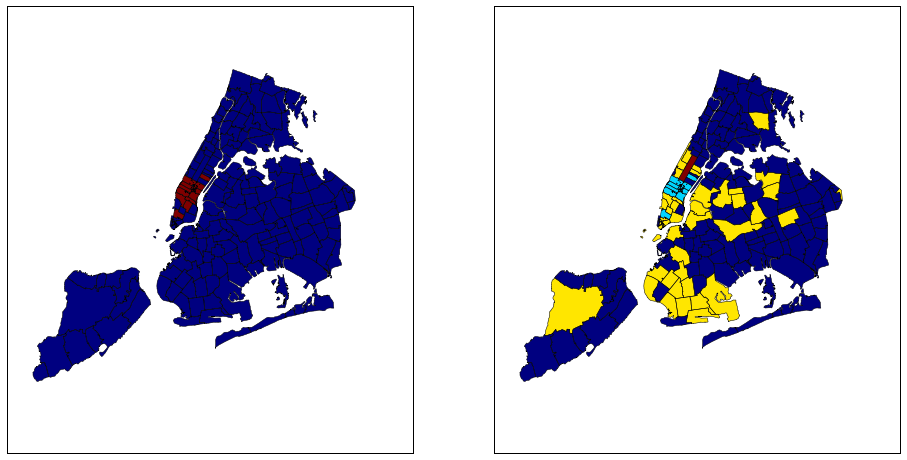

In [142]:
fig = plt.figure(figsize=(16,8)) 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

mergeData.plot(column = 'k2', alpha=1,linewidth=0.5,ax=ax1)
mergeData.plot(column = 'k4', alpha=1,linewidth=0.5,ax=ax2)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


## Figure 1
Map with NYC zipcodes colored accordingly to the cluster (with 2 and 4 clusters). We cluster based on the deviation from the mean in the amount of bussines in a given year. Therefore, zipcodes in the same cluster means that they are similar to each other in this terms. That means that every year they kept the same relative position in terms of amount of bussines. In a way, clusters are a proxy of consistency in time. If we use 2 clusters, we should come with one group of zipcodes with has, in a consisten way across time, higher values than the mean. In the other hand, the other we would have zipcodes consistently below the mean in terms of amount of bussiness. If we use more clusters, we could come up with zipcodes with high or low amount of bussines, but also some groups within them that are not so consisten, that with time they have grown economically or where affected by the crisis. Using 4 has the dissadvantage of the Central park as an outlier and a cluster by its own.

In [160]:
for y in years:
    print mergeData.loc[mergeData.k2==1,[str(y)]].mean()
    print mergeData.loc[mergeData.k2==0,[str(y)]].mean()

1994    3.880139
dtype: float64
1994   -0.191612
dtype: float64
1995    3.837987
dtype: float64
1995   -0.191899
dtype: float64
1996    3.804137
dtype: float64
1996   -0.192615
dtype: float64
1997    3.850982
dtype: float64
1997   -0.192549
dtype: float64
1998    3.852363
dtype: float64
1998   -0.192618
dtype: float64
1999    3.856244
dtype: float64
1999   -0.193619
dtype: float64


TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

The map of the clusters may look something like this

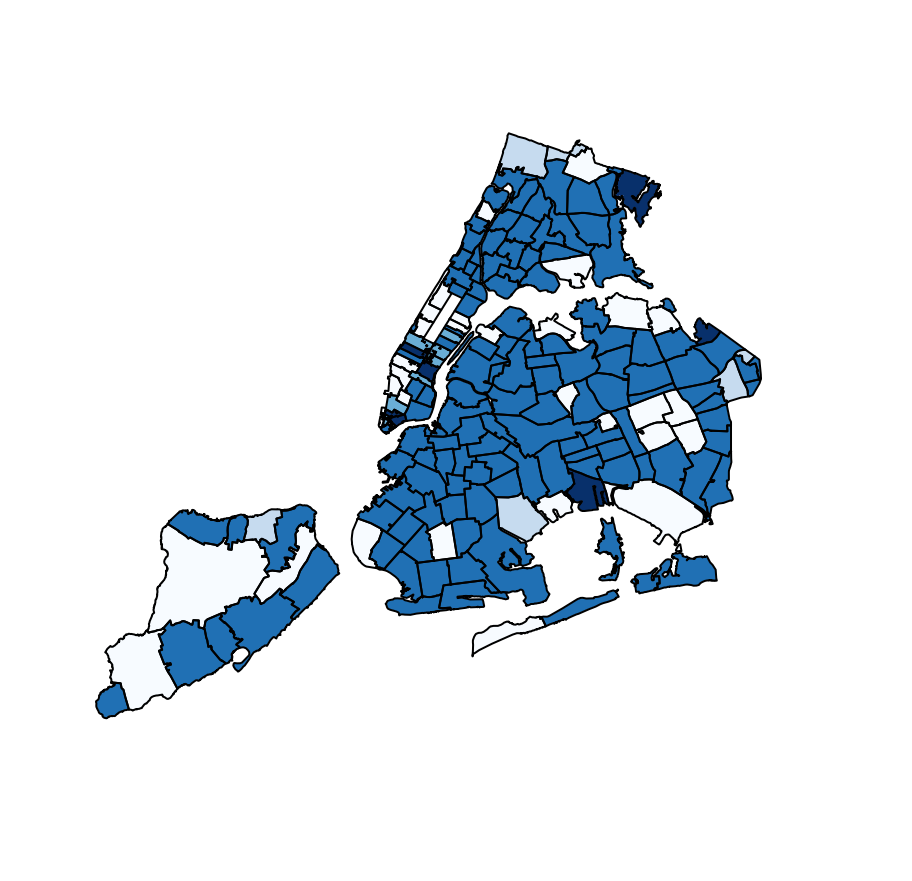

In [3]:
from PIL import Image
Image.open("clustermap.png")

And if you use hierarchical clustering and make a dandrogram it may look like this`

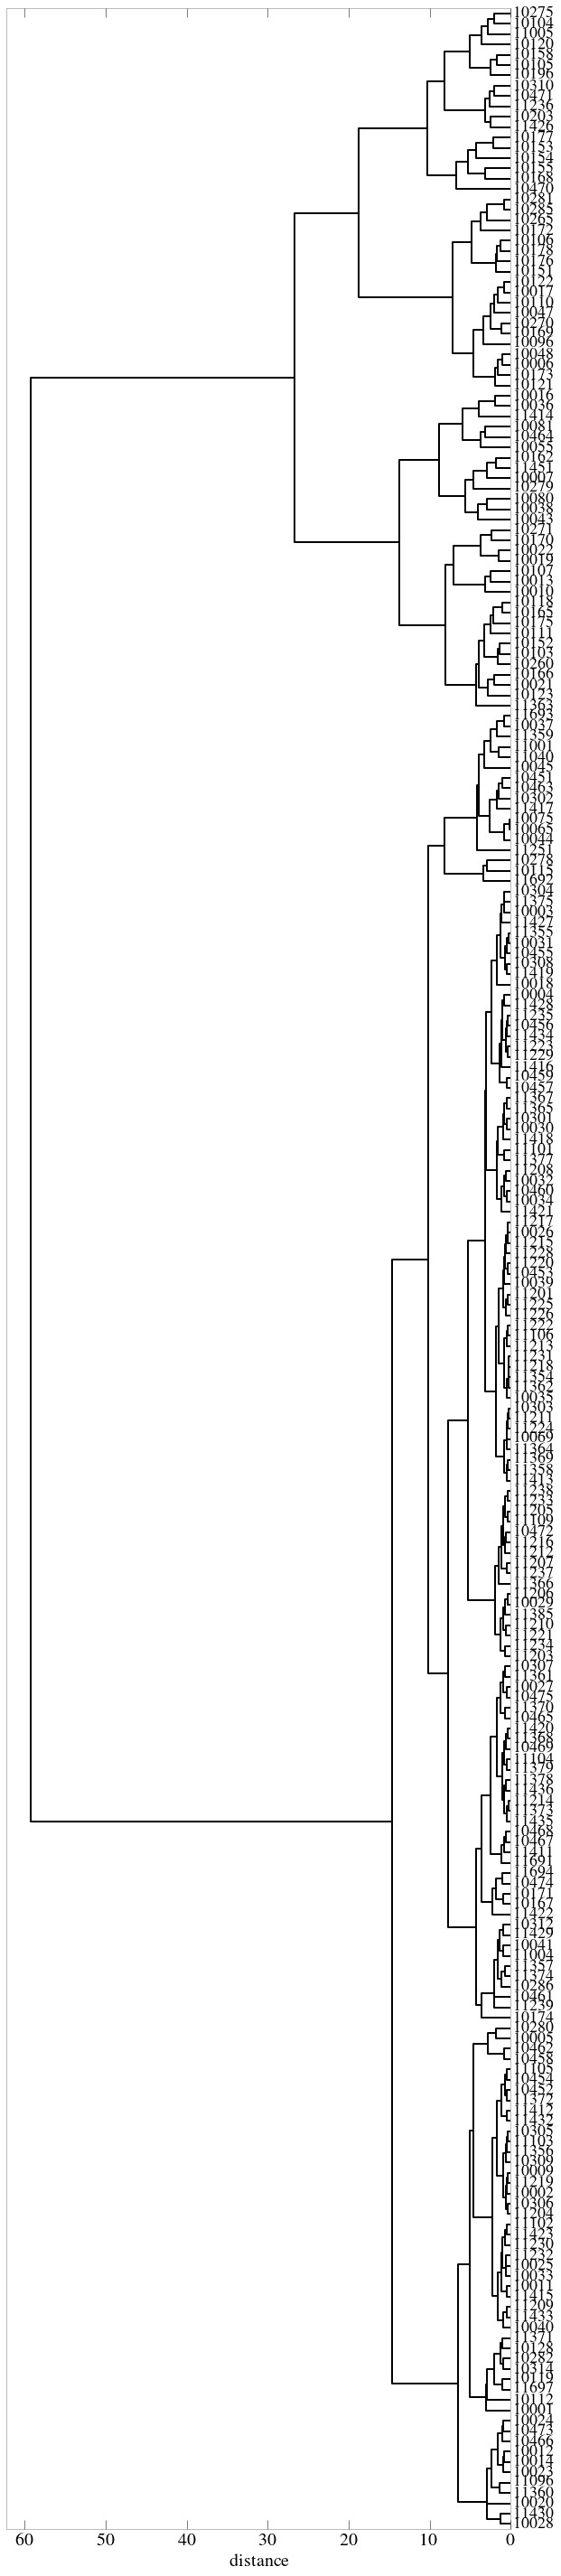

In [4]:
from PIL import Image
Image.open("dandrogram.png")